# Annotation Metadata Review Strategy

## Overview

This notebook provides an interactive analysis of annotation metadata across DCC data models.

## For DCC Data (Primary Importance)

Annotation metadata in Synapse feed the DCC portals and are viewable to users in Synapse when browsing through projects they can see. Some annotations are also indexed into search to help users find the most relevant results. Overall, annotations serve the purpose of data discovery and can be viewable even on controlled-access data for non-logged in users. Annotations can be exposed to third parties for improved findability, **as long as these annotations count as low-risk, non-sensitive information** suitable for the public domain. For DCC data where Sage is most responsible, *because* we are now facilitating annotation access to AI companies via MCP, we want to be confident that **DCC-managed data** have annotations considered allowable for consumption by third parties.

For DCCs, annotations are submitted to Synapse only after validation and potential data transformation (masking) through a curation application (DCA) that enforces the allowed attributes, values, and transformation rules defined in the DCC data model for each "template". An "Annotation Template" defines what **annotations** (keys and values) can be submitted for on an entity such as a project, dataset, folder, file, etc. Another type of "Record Template" defines the internal **content and format** (columns, values) of a CSV file or a Synapse table. This is an important distinction. Operationally, sensitive data/metadata **must** be submitted as a CSV file or Synapse table, so that AR can be applied on these entities (ARs cannot be applied on annotations). The DCC specifies this by using the "record" configuration for the appropriate template in the standard curation application (DCA) so that during curation workflow, values are submitted into a file or table. **This means that, theoretically, no sensitive data end up as annotations, as long as the DCCs has defined their data model judiciously and the configuration correctly.** The MCP currently does not enable any functionality with "download" scope, so AI services will not be able to see any CSV file or Synapse table content (this requires *download* scope).

The task is do an analysis all DCC Annotation Templates, since values submitted from these templates are transferred to Synapse as annotations. For all Annotation Templates, we can classify the present attributes, permissible values/range, and data transformation rules to judge how much of a risk the metadata would be as an annotation.

## Setup and Data Loading

In [56]:
# Import required libraries
from rdflib import Graph, Namespace
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [57]:
# Load RDF graph with data models and enrichment data
def load_graph():
    """Load both data model and enrichment RDF graphs."""
    g = Graph()
    
    # Load data models
    print("Loading data model TTL files...")
    for f in sorted(Path('data_models_rdf').glob('*.ttl')):
        g.parse(f, format='turtle')
        print(f"  ✓ {f.name}")
    
    # Load enrichment
    print("\nLoading enrichment TTL files...")
    for f in sorted(Path('template_enrichment_rdf').glob('*.ttl')):
        g.parse(f, format='turtle')
        print(f"  ✓ {f.name}")
    
    print(f"\n📊 Total graph: {len(g):,} triples loaded\n")
    return g

# Load the graph
graph = load_graph()

Loading data model TTL files...
  ✓ ADKP_data_model.ttl
  ✓ AMP-AIM_data_model.ttl
  ✓ BTC_data_model.ttl
  ✓ CB_data_model.ttl
  ✓ EL_data_model.ttl
  ✓ GF_data_model.ttl
  ✓ HTAN2_data_model.ttl
  ✓ HTAN_data_model.ttl
  ✓ MC2_data_model.ttl
  ✓ NF-OSI_data_model.ttl
  ✓ VEOIBD_data_model.ttl

Loading enrichment TTL files...
  ✓ ADKP_enrichment.ttl
  ✓ AMP-AIM_enrichment.ttl
  ✓ BTC_enrichment.ttl
  ✓ CB_enrichment.ttl
  ✓ EL_enrichment.ttl
  ✓ GF_enrichment.ttl
  ✓ HTAN2_enrichment.ttl
  ✓ HTAN_enrichment.ttl
  ✓ MC2_enrichment.ttl
  ✓ NF-OSI_enrichment.ttl
  ✓ VEOIBD_enrichment.ttl

📊 Total graph: 283,773 triples loaded



## Template Distribution Analysis

The table below summarizes the templates across the latest DCC data models in GitHub. A template can be configured as:
- **Record Template**: Defines internal content/format of CSV files or Synapse tables (sensitive data)
- **Annotation Template** (Metadata): Defines annotations (keys/values) for entities (usually for files, sometimes for folders or dataset entities)
- **Unconfigured**: Not surfaced in curation workflow (draft or abstract templates)

In [58]:
# Query template distribution by project and type
query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?project ?templateType (COUNT(?template) as ?templateCount)
WHERE {
  ?template a ?templateType .
  FILTER(?templateType IN (dca:AnnotationTemplate, dca:RecordTemplate, dca:UnconfiguredTemplate))
  
  # Extract project from URI
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
}
GROUP BY ?project ?templateType
ORDER BY ?project ?templateType
"""

results = graph.query(query)

# Convert to pandas DataFrame
data = []
for row in results:
    template_type = str(row.templateType).split('/')[-1]
    data.append({
        'Project': str(row.project),
        'Type': template_type,
        'Count': int(row.templateCount)
    })

df = pd.DataFrame(data)

# Pivot to create summary table
pivot_df = df.pivot(index='Project', columns='Type', values='Count').fillna(0).astype(int)

# Rename columns for clarity
column_map = {
    'AnnotationTemplate': 'Annotation',
    'RecordTemplate': 'Record',
    'UnconfiguredTemplate': 'Unconfigured'
}
pivot_df = pivot_df.rename(columns=column_map)

# Ensure all columns exist
for col in ['Annotation', 'Record', 'Unconfigured']:
    if col not in pivot_df.columns:
        pivot_df[col] = 0

# Reorder columns
pivot_df = pivot_df[['Annotation', 'Record', 'Unconfigured']]

# Add total column
pivot_df['Total'] = pivot_df.sum(axis=1)

# Reorder to match original table
pivot_df = pivot_df[['Total', 'Annotation', 'Record', 'Unconfigured']]

# Add Grand Total row
grand_total = pivot_df.sum()
grand_total.name = 'Grand Total'
pivot_df = pd.concat([pivot_df, grand_total.to_frame().T])

# Display the table
print("\n📊 Template Distribution by Project and Type\n")
display(pivot_df)


📊 Template Distribution by Project and Type



Type,Total,Annotation,Record,Unconfigured
ADKP,32,1,28,3
AMP-AIM,20,2,1,17
BTC,8,1,0,7
CB,2,0,0,2
EL,17,11,4,2
GF,40,7,1,32
HTAN,135,62,27,46
HTAN2,136,63,28,45
MC2,37,1,11,25
NF-OSI,49,23,1,25


### Interpretation

To give a better comparison for the above table:
- **ADKP** is conservative in that all metadata are locked away as files, even technical assay metadata that are normally considered low risk. There are only two Annotation Templates. One for adding annotation metadata about data file entities, and the other for adding annotation metadata about analysis file entities.
- On the other end of the spectrum, **NF-OSI** has mostly file Annotation Templates and only one Record Template.

### Example Annotation Templates by DCC

Let's look at one example Annotation Template from each DCC to understand what they're used for.

In [59]:
# Query for one example Annotation Template from each DCC
example_query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?project ?template ?templateName ?description
WHERE {
  ?template a dca:AnnotationTemplate .
  
  # Extract project from URI
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
  
  # Get template name and description
  OPTIONAL { ?template rdfs:label ?label }
  OPTIONAL { ?template rdfs:comment ?description }
  
  # Extract template name (use label if available, otherwise URI fragment)
  BIND(IF(BOUND(?label), ?label, 
     REPLACE(STR(?template), ".*[/#]([^/#]+)$", "$1")) AS ?templateName)
}
ORDER BY ?project ?template
"""

example_results = list(graph.query(example_query))

# Get one example per project
seen_projects = set()
example_data = []

for row in example_results:
    project = str(row.project)
    if project not in seen_projects:
        seen_projects.add(project)
        example_data.append({
            'Project': project,
            'Template Name': str(row.templateName),
            'Description': str(row.description) if row.description else 'N/A'
        })

example_df = pd.DataFrame(example_data)

print("\n📋 Example Annotation Template from Each DCC\n")
display(example_df)


📋 Example Annotation Template from Each DCC



,Project,Template Name,Description
0,ADKP,FileAnnotationTemplate,AD file annotation template schema
1,AMP-AIM,CyTOFSDPAnnotationTemplate,A component for collecting file-level metadata...
2,BTC,BulkRNA-seqLevel1,Bulk RNA-seq [EFO_0003738]
3,EL,AssayBsSeqTemplate,Template for bsSeq
4,GF,ImagingLevel2,TBD
5,HTAN,10XGenomicsXeniumISSExperiment,All data pertaining to the 10X Genomics Xenium...
6,HTAN2,10XGenomicsXeniumISSExperiment,All data pertaining to the 10X Genomics Xenium...
7,MC2,FileView,The denormalized manifest for file submission.
8,NF-OSI,BehavioralAssayTemplate,Template for behavioral assay data from model ...


## Discussion: Strengths and Limitations

### Assumptions and Limitations

Unconfigured Templates:
  - We assume that Unconfigured templates are not actively used. In reality, some Unconfigured templates may be in used in specific contexts or there may be annotation activity outside fo the DCC's official standards/workflow.

Annotation Visibility:
- Focuses on what *could* be exposed as annotations based on the data model
- Actual annotation exposure depends on runtime configuration and user behavior
- Not all attributes are required in an Annotation Template and therefore actually populated

Configuration Changes:
- These latest data models in GitHub represent a snapshot in time. We're not looking at data management historically. Also, templates may change after this analysis.

### Strengths

Systematic Approach and Clear Risk Surface
- Analyzes all DCC data models systematically
- Provides quantitative metrics across all projects for comparison
- Identifies the exact templates and attributes that produce annotations
- Enables focused review of annotation-producing templates

Data-Driven and Reproducible
- Uses RDF/SPARQL queries for reproducible analysis
- Can be re-run as data models evolve

Comparative Analysis
- Highlights different approaches (conservative vs liberal) across DCCs
- Provides context for understanding risk management strategies


## Visualization: Template Type Distribution

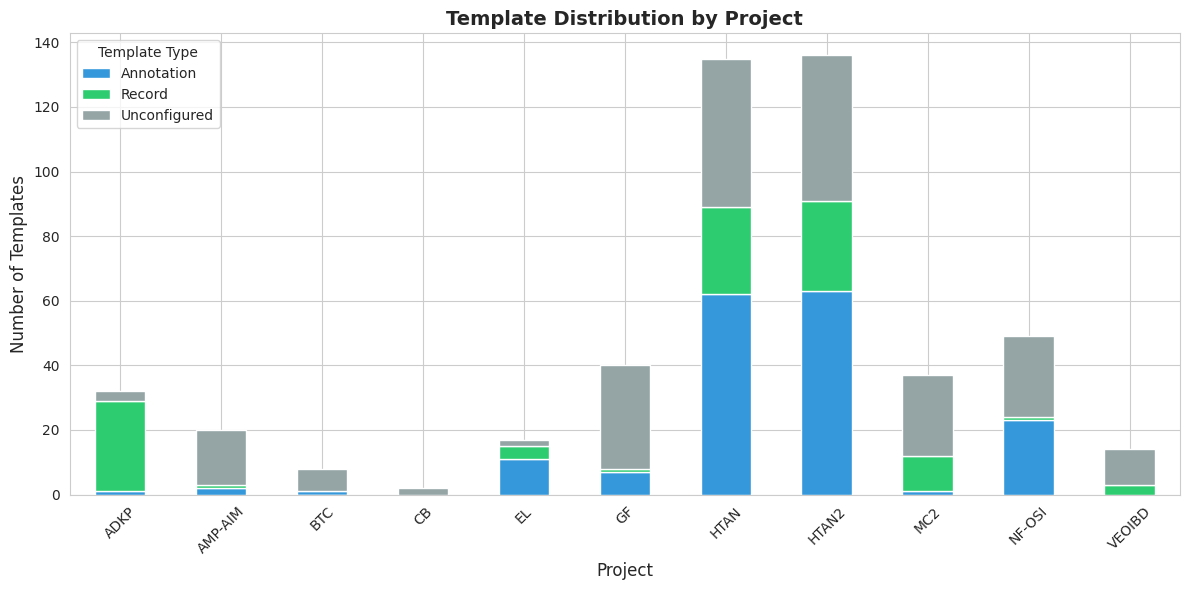

In [60]:
# Create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Remove Grand Total for visualization
plot_df = pivot_df.iloc[:-1]

# Stacked bar chart
plot_df[['Annotation', 'Record', 'Unconfigured']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['#3498db', '#2ecc71', '#95a5a6']
)
ax.set_title('Template Distribution by Project', fontsize=14, fontweight='bold')
ax.set_xlabel('Project', fontsize=12)
ax.set_ylabel('Number of Templates', fontsize=12)
ax.legend(title='Template Type', loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [61]:
# Get all Annotation Templates with their attributes
annotation_query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?project ?template ?templateLabel (COUNT(DISTINCT ?attribute) as ?attributeCount)
WHERE {
  ?template a dca:AnnotationTemplate .
  
  OPTIONAL { ?template rdfs:label ?templateLabel }
  
  # Get attributes
  OPTIONAL { ?template dca:requiresDependency ?attribute }
  
  # Extract project from URI
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
  
  # Extract template name from URI
  BIND(IF(BOUND(?templateLabel), ?templateLabel, 
     REPLACE(STR(?template), ".*[/#]([^/#]+)$", "$1")) AS ?name)
}
GROUP BY ?project ?template ?templateLabel
ORDER BY ?project ?name
"""

annotation_results = graph.query(annotation_query)

# Convert to DataFrame
annotation_data = []
for row in annotation_results:
    template_name = str(row.templateLabel) if row.templateLabel else str(row.template).split('/')[-1]
    annotation_data.append({
        'Project': str(row.project),
        'Template': template_name,
        'Attribute Count': int(row.attributeCount)
    })

annotation_df = pd.DataFrame(annotation_data)

print(f"\n📋 Found {len(annotation_df)} Annotation Templates\n")
print("Sample of Annotation Templates:")
display(annotation_df.head(20))

# Summary statistics
print("\n📊 Summary Statistics:")
print(f"  Total Annotation Templates: {len(annotation_df)}")
print(f"  Average attributes per template: {annotation_df['Attribute Count'].mean():.1f}")
print(f"  Median attributes per template: {annotation_df['Attribute Count'].median():.1f}")
print(f"  Max attributes in a template: {annotation_df['Attribute Count'].max()}")
print(f"  Templates with 0 attributes: {(annotation_df['Attribute Count'] == 0).sum()}")


📋 Found 171 Annotation Templates

Sample of Annotation Templates:


,Project,Template,Attribute Count
0,ADKP,FileAnnotationTemplate,17
1,AMP-AIM,CyTOFSDPAnnotationTemplate,7
2,AMP-AIM,OlinkFileAnnotationTemplate,4
3,BTC,BulkRNA-seqLevel1,55
4,EL,AssayRNAseqTemplate,20
5,EL,AssayBsSeqTemplate,32
6,EL,AssayMetabolomicsTemplate,47
7,EL,AssayMetagenomicsTemplate,36
8,EL,AssayMicrobiomeTemplate,24
9,EL,AssayProteomicsTemplate,27



📊 Summary Statistics:
  Total Annotation Templates: 171
  Average attributes per template: 22.0
  Median attributes per template: 20.0
  Max attributes in a template: 65
  Templates with 0 attributes: 0


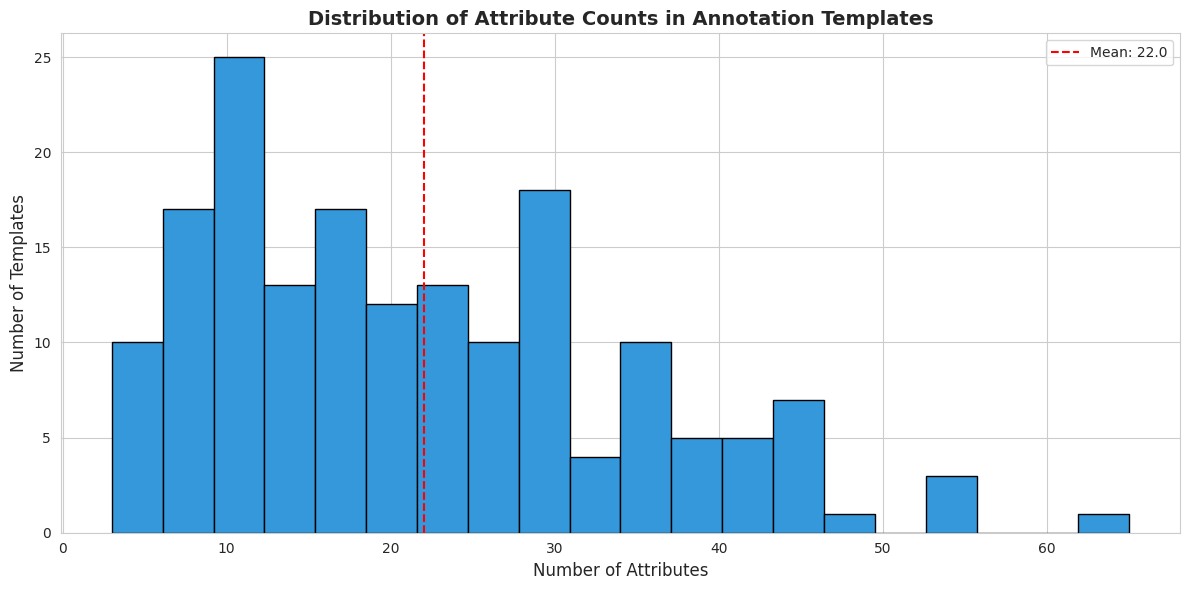

In [62]:
# Visualize attribute distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Histogram of attribute counts
annotation_df['Attribute Count'].hist(bins=20, ax=ax, color='#3498db', edgecolor='black')
ax.set_title('Distribution of Attribute Counts in Annotation Templates', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Attributes', fontsize=12)
ax.set_ylabel('Number of Templates', fontsize=12)
ax.axvline(annotation_df['Attribute Count'].mean(), color='red', linestyle='--', label=f"Mean: {annotation_df['Attribute Count'].mean():.1f}")
ax.legend()

plt.tight_layout()
plt.show()

## Attribute-Level Analysis

Let's look at the actual attributes used in Annotation Templates to understand what metadata is exposed.

In [63]:
# Query for all attributes in Annotation Templates
attribute_query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>

SELECT DISTINCT ?attribute ?label ?description ?project
WHERE {
  ?template a dca:AnnotationTemplate .
  ?template dca:requiresDependency ?attribute .
  
  ?attribute rdfs:label ?label .
  OPTIONAL { ?attribute rdfs:comment ?description }
  
  # Extract project
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
}
ORDER BY ?label
"""

attribute_results = graph.query(attribute_query)

# Convert to DataFrame
attr_data = []
for row in attribute_results:
    attr_data.append({
        'Attribute': str(row.label),
        'Description': str(row.description) if row.description else 'N/A',
        'Project': str(row.project),
        'URI': str(row.attribute)
    })

attr_df = pd.DataFrame(attr_data)

print(f"\n📋 Found {len(attr_df)} unique attributes across Annotation Templates\n")
print("Sample attributes:")
display(attr_df.head(20))

# Count attribute usage across projects
attr_counts = attr_df['Attribute'].value_counts()
print(f"\n🔄 Attribute Reuse:")
print(f"  Attributes used in multiple projects: {(attr_counts > 1).sum()}")
print(f"  Most commonly used attribute: '{attr_counts.index[0]}' ({attr_counts.iloc[0]} projects)")


📋 Found 1322 unique attributes across Annotation Templates

Sample attributes:


,Attribute,Description,Project,URI
0,AbNameReportedonDataset,The antibody name.,HTAN2,https://dca.app.sagebionetworks.org/HTAN2/AbNa...
1,AbNameReportedonDataset,The antibody name.,HTAN,https://dca.app.sagebionetworks.org/HTAN/AbNam...
2,AccessReqs,TBD,EL,https://dca.app.sagebionetworks.org/EL/AccessReqs
3,AckContext,TBD,EL,https://dca.app.sagebionetworks.org/EL/AckContext
4,Acknowledgment,TBD,EL,https://dca.app.sagebionetworks.org/EL/Acknowl...
5,AcquisitionBatchID,"Acquisition batch identifier, provided by the ...",EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
6,AcquisitionBatchSize,The number of samples,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
7,AcquisitionBatchSizeUnit,The unit of measurement for number of samples ...,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
8,AcquisitionMode,The specific aspect of a mass spectrometer met...,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
9,AcquisitionSoftware,The name of the acquisition software used. Pro...,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...



🔄 Attribute Reuse:
  Attributes used in multiple projects: 431
  Most commonly used attribute: 'Component' (9 projects)


## For Independent Users

For users outside DCC management, there is no additional vetting for annotations; users can add any annotations they want to their private project assets, then use AI with their private projects. In this case, the user owns their data and it is up to them to understand the implications. Currently, the best approach is to add reminders and disclaimers to public docs.

## Export Analysis Data

In [ ]:
# Export summary data for further analysis
import os

# Create output directory if it doesn't exist
output_dir = 'notebook_data'
os.makedirs(output_dir, exist_ok=True)

# Export to notebook_data folder
pivot_df.to_csv(f'{output_dir}/template_distribution_summary.csv')
annotation_df.to_csv(f'{output_dir}/annotation_templates_detail.csv', index=False)

print("✅ Exported analysis data to notebook_data/:")
print("  - template_distribution_summary.csv")
print("  - annotation_templates_detail.csv")

## References

- [Annotating Data With Metadata - Synapse Documentation](https://help.synapse.org/docs/Annotating-Data-With-Metadata.2667708522.html)